# Reliability assessment parapet quay walls (port of Merak)

In [6]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("default")

## Input parameters and their probabilistic distributions

In [7]:
N = 10000 #Number of Monte Carlo runs
zeros = np.zeros(N)

#HEIGHTS i.r.t LAT

#Loads
SLR_mean = 0 # [m]
Hwaves_mean = 1 # [m]

#waterlevels

hw_mean = 10 # [m]
HAT_mean = 1 # [m]
MSL_mean = 0.53 # [m]
hcrest_mean = 3.1 # [m]
DWL_mean = 1.5 # [m]


#parapet data
hr_mean = 0.5 # [m]
Br_mean = 0.5 # [m]


#other parameters
Tm1_mean = 3.8 # [s]
g_mean = 9.81 #[m/s^2]


#guidelines
overtopping_R = 5 # [l/s/m]


#Distributions
hcrest = scipy.stats.norm(hcrest_mean, 0.05*hcrest_mean).rvs(N)
DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
hw = scipy.stats.norm(hw_mean, 0.05*hw_mean).rvs(N)
Tm1 = scipy.stats.norm(Tm1_mean, 0.05*Tm1_mean).rvs(N)
g = scipy.stats.norm(g_mean, 0.0).rvs(N)
overtopping = scipy.stats.norm(overtopping_R,0.05*overtopping_R).rvs(N)
hr = scipy.stats.norm(hr_mean,0.05*hr_mean).rvs(N)
Br = scipy.stats.norm(Br_mean,0.05*Br_mean).rvs(N)

## Limit State Functions

In [8]:
def Overtopping(hw, overtopping, hcrest, Tm1,  Hwaves_mean, SLR_mean, DWL_mean, hr, Br):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
    Rc = hcrest - DWL - SLR
    Lm1 = (g*Tm1**2) / (2*np.pi)
    h_impuls = (hw/Hwaves)*((2*np.pi*hw)/(g*Tm1**2))
    sm1 = Hwaves / Lm1 
    
    htoe = hw + SLR + DWL
    R0 = 0.25 * hr/Br + 0.05 *hr/Rc
    m = 0.88*np.sqrt(hr/Br) + 0.16* hr/Rc
    k = 0.2 - 0.01*(Rc/Hwaves - R0 - m)
    
    if np.nanmean(R0) > np.nanmean(Rc)/ np.nanmean(Hwaves):
        k_bn = 1
    elif np.nanmean(Rc) / np.nanmean(Hwaves) > np.nanmean(R0) and np.nanmean(Rc) / np.nanmean(Hwaves) < np.nanmean(R0+ m) :
        k_bn = (0.8/m) * ((Rc/Hwaves)-R0)
    if np.nanmean(Rc) / np.nanmean(htoe) < 0.6:
        k_bn = k
    if np.nanmean(Rc) / np.nanmean(htoe) > 0.6 and np.nanmean(Rc) / np.nanmean(htoe) < 1.1:
        k_bn = 180*k*np.exp(-8.5*(Rc/Hwaves))
    if np.nanmean(Rc) / np.nanmean(htoe) > 1.1:
        k_bn = 0.02*k
    if np.nanmean(hr) < 0.1:
        k_bn = 1.0
    
    if np.nanmean(h_impuls) > 0.23:
        S_overtopping = k_bn*(((g*Hwaves**3)**0.5)*(0.023)*np.exp(-2.7*Rc/(Hwaves))*1000)
    elif np.nanmean(h_impuls) < 0.23 and np.nanmean(Rc)/np.nanmean(Hwaves) < 1.35:
        S_overtopping = k_bn*(((g*Hwaves**3)**0.5)*(0.011)*((Hwaves/(hw*sm1))**0.5)*np.exp(-2.2*Rc/(Hwaves))*1000)
    elif np.nanmean(h_impuls) < 0.23 and np.nanmean(Rc)/np.nanmean(Hwaves) > 1.35:
        S_overtopping = k_bn*((((g*Hwaves**3)**0.5)*(0.011)*((Hwaves/(hw*sm1))**0.5)*(-2.2*Rc/(Hwaves))**-3)*1000)
    R_overtopping = overtopping
    LS_overtopping = R_overtopping - S_overtopping 
    return LS_overtopping

N_overtopping = np.less_equal(Overtopping(hw, overtopping, hcrest, Tm1, Hwaves_mean, SLR_mean, DWL_mean, hr, Br), zeros)
failure_overtopping = np.sum(N_overtopping) / float(N)

## Computations of fragility curves (Monte Carlo analysis)

Text(0.5, 0, 'DWL [m]')

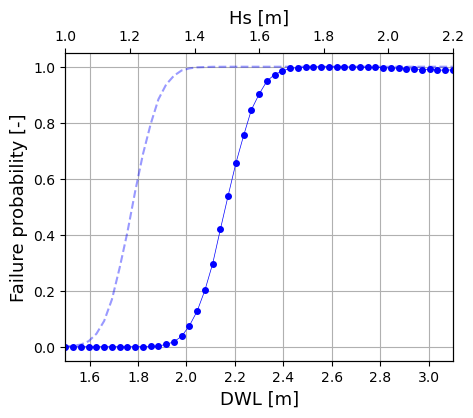

<Figure size 500x400 with 0 Axes>

In [11]:
list_overtopping = []
N_vertical = 50 #Number of data points horizontal acis fragility curve


#Min and max values for the different loads
SLR_max = 1.6
SLR_min = 0

Hwaves_max = 3 # offshore wave heigth
Hwaves_min = 0.5


SLR_range =np.arange(SLR_min,1.001*SLR_max ,(SLR_max-SLR_min)/N_vertical)
Hwaves_range = np.arange(Hwaves_min,1.001*Hwaves_max,(Hwaves_max-Hwaves_min)/N_vertical)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)


#Choose type of hydraulic loading which will gradually increase
# 1 = rising water levels (sea level rise)
# 2 = rising wave height
# 3 = combination of both when incoming waves are depth-limited

x = 3


if x == 1:
    a = SLR_range
    c = scipy.stats.norm(Hwaves_mean, 0.0).rvs(N)
    d = a + DWL_mean
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    title = 'Pf vs DWL' 
    xas = 'DWL [m]'
    yas = 'Probability of failure (Pf)'
elif x == 2:
    a = scipy.stats.norm(SLR_mean, 0.0).rvs(N)
    c = Hwaves_range
    d = c 
    ax1.set_xlim(Hwaves_min,  Hwaves_max)
    title = 'Pf vs Hs'
    xas = 'Hs [m]'
    yas = 'Probability of failure (Pf)'
elif x == 3:
    DWL = scipy.stats.norm(DWL_mean, 0.0*DWL_mean).rvs(N)
    a = SLR_range 
    c =  (Hwaves_mean + 0.75*SLR_range)
    d = a + DWL_mean
    title = 'Quay wall Port of Merak'
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
    ax2 = ax1.twiny()
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
    ax2.set_xlabel('Hs [m]', size = 13)


for i in range(len(d)):
    SLR_mean = a[i]
    Hwaves_mean = c[i]
    failure_overtopping = np.sum(np.less_equal(Overtopping(hw, overtopping, hcrest, Tm1,   Hwaves_mean, SLR_mean, DWL_mean, hr, Br), zeros)) / float(N)
    list_overtopping.append(failure_overtopping)

    
#conditional failure probabilities extracted from the file 'Reliability_assessment_quaywall _Merak'
old_overtopping = [0.0008, 0.0034, 0.0077, 0.0198, 0.0461, 0.092, 0.1687, 0.282, 0.4091, 0.5543, 0.687, 0.795, 0.8835, 0.9365, 0.9678, 0.9867, 0.994, 0.9978, 0.9988, 0.9998, 0.9998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
old_total = [0.0438655200000001, 0.04984155999999995, 0.06078804999999998, 0.07674962000000007, 0.10896200999999994, 0.15846559999999998, 0.2376978999999999, 0.3461892000000001, 0.46759910000000005, 0.60190076, 0.7236836, 0.820748, 0.89933235, 0.94566305, 0.97284896, 0.988914007642, 0.9950608, 0.99821687052, 0.99903995344, 0.99984181236, 0.9998456113404101, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
old_overflow =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0003, 0.0009, 0.0024, 0.0047, 0.01, 0.0187, 0.0309, 0.0512, 0.0844, 0.1235, 0.1779, 0.2465, 0.3208, 0.4114, 0.5018, 0.6074, 0.6845, 0.7615, 0.8221, 0.8779, 0.9171, 0.9465, 0.9647, 0.9772, 0.9879, 0.9938, 0.9959, 0.9981, 0.9992, 0.9995]
old_impact = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    

    
plt.figure(figsize=(5,4))
ax1.plot(d,old_overtopping, label = 'No parapet', color = 'blue', alpha = 0.4, linestyle = '--')
ax1.plot(d,list_overtopping, label = 'Overtopping',color = 'blue', linewidth = 0.5, marker ='.', markersize = '8')
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size = 13)

## Efficacy of structural adaptation i.r.t the original structure

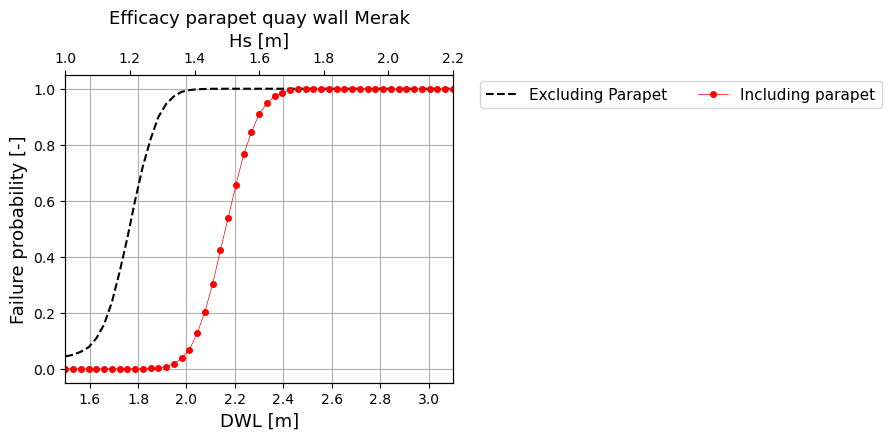

In [10]:
list_new = []

#Combining old failure probabilities for unaffected limit state functions with the newly computed ones for the affected ones
for i in range(N_vertical+1):
    Pf_independent = 1-((1-old_overflow[i])*(1-list_overtopping[i])*(1-old_impact[i])) #Failure top event 
    list_new.append(Pf_independent)

#reiterate wave height to ensure correct increase of legend 
Hwaves_mean = 1
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
ax2.set_xlabel('Hs [m]', size = 13)
ax1.plot(d,old_total, label = 'Excluding Parapet', color = 'black', linestyle = '--')
ax1.plot(d,list_new, label = 'Including parapet' , color = 'red', linewidth = 0.5, marker ='.', markersize = '8')
ax1.set_title('Efficacy parapet quay wall Merak', size = 13)
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size=13)
ax1.legend(bbox_to_anchor=(1.05, 1.005), loc='upper left', ncol = 2,  prop={"size":11})
plt.show()